## The BIG Wine Dataset
 ** explain what I'm gonna do in this notebook ** 
The dataset consists of the following columns:

Attribute Information
+ winery: Winery name
+ wine: Name of the wine
+ year: Year in which the grapes were harvested
+ rating: Average rating given to the wine by the users [from 1-5]
+ num_reviews: Number of users that reviewed the wine
+ country: Country of origin [Spain]
+ region: Region of the wine
+ price: Price in euros [€]
+ type: Wine variety
+ body: Body score, defined as the richness and weight of the wine in your mouth [from 1-5]
+ acidity: Acidity score, defined as wine's “pucker” or tartness; it's what makes a wine refreshing and your tongue + salivate and want another sip [from 1-5]

In [40]:
# seaborn to explore the data
import seaborn as sea

# as a relatively small dataset, the use of pandas is okay
import pandas as pd

import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [41]:
wine_ds = pd.read_csv("data/wines_SPA.csv")

In [65]:
print(wine_ds.head())
wine_ds = wine_ds.dropna()
# np.array(wine_ds['year']).astype('int')

wine_ds = wine_ds[wine_ds['year'] != 'N.V.']
wine_ds['year'] = wine_ds['year'].astype('int')


          winery           wine  year  rating  num_reviews country  \
0  Teso La Monja          Tinto  2013     4.9           58  Espana   
1         Artadi  Vina El Pison  2018     4.9           31  Espana   
2   Vega Sicilia          Unico  2009     4.8         1793  Espana   
3   Vega Sicilia          Unico  1999     4.8         1705  Espana   
4   Vega Sicilia          Unico  1996     4.8         1309  Espana   

             region   price                  type  body  acidity  
0              Toro  995.00              Toro Red   5.0      3.0  
1    Vino de Espana  313.50           Tempranillo   4.0      2.0  
2  Ribera del Duero  324.95  Ribera Del Duero Red   5.0      3.0  
3  Ribera del Duero  692.96  Ribera Del Duero Red   5.0      3.0  
4  Ribera del Duero  778.06  Ribera Del Duero Red   5.0      3.0  


In [66]:
#The data is not very sparse. It sunks on different buckets. A bucketized feature could be useful for the "year" att
# sea.displot(wine_ds, x = "year")

# If the label we want to predict is "rating", a dropout layer (in training) could be usefull because of the huuge 
# difference between the quantity of the buckets:
# sea.displot(wine_ds, x = "rating")

# a lot of data is filled in certain buckets:
# sea.displot(wine_ds, x = "body")
# sea.displot(wine_ds, x = "acidity")

wine_ds.groupby("num_reviews").count() 

,winery,wine,year,rating,country,region,price,type,body,acidity
num_reviews,,,,,,,,,,
25,17,17,17,17,17,17,17,17,17,17
26,15,15,15,15,15,15,15,15,15,15
27,20,20,20,20,20,20,20,20,20,20
28,25,25,25,25,25,25,25,25,25,25
29,17,17,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...,...
8318,1,1,1,1,1,1,1,1,1,1
9092,1,1,1,1,1,1,1,1,1,1
9098,1,1,1,1,1,1,1,1,1,1


In [67]:
# Country column has only 1 value: poping
# wine_ds['country'].unique()
# wine_ds.pop('country')
wine_ds['type'].unique()

array(['Toro Red', 'Tempranillo', 'Ribera Del Duero Red', 'Pedro Ximenez',
       'Red', 'Priorat Red', 'Rioja Red', 'Rioja White', 'Grenache',
       'Cava', 'Sherry', 'Verdejo', 'Syrah', 'Monastrell', 'Mencia',
       'Sparkling', 'Montsant Red', 'Albarino', 'Chardonnay',
       'Cabernet Sauvignon', 'Sauvignon Blanc'], dtype=object)

Now it's time to create the features. All the features will be feeded into feature_columns array. We'll be testing several models:
+ A baseline model
+ A model that uses all the features
+ A model that uses all the features but with a filtered dataset
+ A model that uses certain features with a filtered dataset

As seen in the plots, there's a lot of variance in the columns, some types of wine have almost none samples compared with others, the same goes for other features. Features with less data than usual can cause overfitting, because there's not enough variance on each type of value of each colum. Thereby, removing some of the categorical types and only leaving the ones that have a modest amount of samples, can help us avoid overfitting. 

For now, let's see how a model with all the columns (except contry, because it only has 1 value) performs:

In [68]:
# 10 att:
numeric_cols = ['year', 'rating', 'num_reviews', 'body', 'acidity']
# rating goes from 4.2 to 5
# num_reviews sparse


categorical_cols = ['winery', 'wine', 'region', 'type']

label = 'price'


In [69]:
feature_columns = []

for i in numeric_cols:
    feature_columns.append(fc.numeric_column(i))

type_vocab = wine_ds['type'].unique()
# for categorical cols:
# for winery (a lot of categories): 
winery_cat = fc.categorical_column_with_hash_bucket('winery', 10000)
feature_columns.append(fc.indicator_column(winery_cat))

# bucketize years:
# buckets = fc.bucketized_column('year', [])

# for type (a bit less categories than winery): 
one_hot_type = fc.categorical_column_with_vocabulary_list('type', vocabulary_list= type_vocab)
feature_columns.append(fc.indicator_column(one_hot_type))

# for wine and region (a lot of categories):
wine_cat = fc.categorical_column_with_hash_bucket('wine', 10000)
feature_columns.append(fc.indicator_column(wine_cat)) 
region_cat = fc.categorical_column_with_hash_bucket('region', 1000)
feature_columns.append(fc.indicator_column(region_cat))

In [70]:
feature_layer = layers.DenseFeatures(feature_columns, dtype = 'float64')

# now a function that converts a pandas dataframe to a tf dataset:
def pandas_to_tensor(dataframe, _shuffle_ = False, batch_size = 10):
    dataframe = dataframe.copy()
    labels = dataframe.pop(label)
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if _shuffle_:
        dataset = dataset.shuffle(len(dataset))
    
    dataset = dataset.batch(batch_size)
    return dataset

In [71]:
model_base = tf.keras.models.Sequential([
    feature_layer,
    layers.Dense(12,input_dim = 10,  activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1, activation='linear', name = 'price')
])

wine_ds = wine_ds.dropna()
train_ds, test_ds = train_test_split(wine_ds, test_size= 0.2)
train_ds, val_ds = train_test_split(train_ds, test_size= 0.2)

train_ds = pandas_to_tensor(train_ds, True, 20)
val_ds = pandas_to_tensor(val_ds, batch_size= 20)

test_ds = pandas_to_tensor(test_ds, batch_size=20)

# Handle NAs better ||
# NAS should be filled with syntetic data if the sample in question
# has enough data from other attributes. Otherwise, the row should be dropped


In [72]:
# Now define the training parameters.
for featres, labels in train_ds.take(1):
    print('Every feature:', list(featres.values()))
    print('A batch of targets:', labels)

NUM_EXAMPLES_TRAIN = len(train_ds)
NUM_EPOCHS = 5
steps_per_epoch = NUM_EXAMPLES_TRAIN//(10 * NUM_EPOCHS)

model_base.compile(optimizer='adam', 
                    loss='mse', 
                    metrics=['mse'])

print(train_ds.take(1))

history_base = model_base.fit(train_ds,
                        validation_data = val_ds,
                        epochs = NUM_EPOCHS,
                        steps_per_epoch = steps_per_epoch)


Every feature: [<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'La Rioja Alta', b'La Rioja Alta', b'Volver', b'Sei Solo',
       b'Teso La Monja', b'La Vicalanda', b'Sierra Cantabria',
       b'Vinedos de Paganos', b'Vinedos de Paganos', b'Bodegas La Horra',
       b'Portal del Priorat', b'Muga', b'Vega Sicilia',
       b"Conreria d'Scala Dei", b'Clos Pons', b'Artadi', b'Matarromera',
       b'Sei Solo', b'Campillo', b'La Rioja Alta'], dtype=object)>, <tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'Vina Alberdi Crianza', b'Gran Reserva 890',
       b'Alicante Bouschet by Tarima', b'Preludio', b'Tinto', b'Reserva',
       b'Coleccion Privada', b'El Puntido', b'El Puntido', b'Corimbo I',
       b'Clos del Portal Somni', b'Prado Enea Gran Reserva', b'Unico',
       b'Les Brugueres', b'Roc Nu', b'Valdegines', b'Gran Reserva',
       b'Preludio', b'Gran Reserva Rioja', b'Vina Alberdi Crianza'],
      dtype=object)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([2018, 201

In [81]:
# A really bad prediction: 
model_base.predict({
    "winery": tf.convert_to_tensor(["Losada"]),
    "wine": tf.convert_to_tensor(["Altos de Losada"]),
    "year": tf.convert_to_tensor([2018]),
    "rating": tf.convert_to_tensor([4.2]),
    "num_reviews": tf.convert_to_tensor([415]),
    "country": tf.convert_to_tensor(["Espana"]),
    "region": tf.convert_to_tensor(["Bierzo"]),
    #"price": tf.convert_to_tensor([17.9]),
    "type": tf.convert_to_tensor(["Mencia"]),
    "body": tf.convert_to_tensor([3]),
    "acidity": tf.convert_to_tensor([3])
}, steps = 1)

array([[40.608402]], dtype=float32)

Now a model with more and better features:

In [82]:
# First normalize every numeric feature:
def normalize_fn(col):
    def min_max(x_row):
        maxi = train_ds[col].max()
        mini = train_ds[col].min()
        return (x_row - maxi)/(maxi - mini)
        return (min_max)

Now the features:

In [102]:
feature_columns = []

# now use the normalizing function:
for i in numeric_cols:
    tabulador = normalize_fn(i)
    feature_columns.append(fc.numeric_column(i, normalizer_fn=tabulador))

# for categorical cols:
# for winery (a lot of categories): 
winery_cat = fc.categorical_column_with_hash_bucket('winery', 10000)
feature_columns.append(fc.indicator_column(winery_cat))

# bucketize years:
# buckets = fc.bucketized_column('year', [])

# for type (a bit less categories than winery): 
one_hot_type = fc.categorical_column_with_vocabulary_list('type', vocabulary_list= type_vocab)
feature_columns.append(fc.indicator_column(one_hot_type))

# for wine and region (a lot of categories):
wine_cat = fc.categorical_column_with_hash_bucket('wine', 10000)
feature_columns.append(fc.indicator_column(wine_cat)) 
region_cat = fc.categorical_column_with_hash_bucket('region', 1000)
feature_columns.append(fc.indicator_column(region_cat))


# The more reviews some wine has, the more credible is its rating:
rating_review = fc.crossed_column(['rating', 'num_reviews'], 1000)
rating_review_embeded = fc.embedding_column(rating_review, dimension=10)
feature_columns.append(rating_review_embeded)

In [103]:
# exploring the year column 
# sea.displot(data = wine_ds, x = 'year')
# wine_ds['year'].describe()

wine_ds.head()
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');    

In [104]:
# now time to compile and train:
# Now define the training parameters.
# for featres, labels in train_ds.take(1):
#     print('Every feature:', list(featres.values()))
#     print('A batch of targets:', labels)
feature_layer = layers.DenseFeatures(feature_columns, dtype = 'float64')

model_v1 = tf.keras.models.Sequential([
    feature_layer,
    layers.Dense(12,input_dim = 10,  activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1, activation='linear', name = 'price')
])

NUM_EXAMPLES_TRAIN = len(train_ds)
NUM_EPOCHS = 10
steps_per_epoch = NUM_EXAMPLES_TRAIN//(10 * NUM_EPOCHS)

model_v1.compile(optimizer='adam', 
                    loss='mse', 
                    metrics=['mse'])

print(train_ds.take(1))

history_v1 = model_v1.fit(train_ds,
                        validation_data = val_ds,
                        epochs = NUM_EPOCHS,
                        steps_per_epoch = steps_per_epoch)


<TakeDataset element_spec=({'winery': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'wine': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'year': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'rating': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'num_reviews': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'country': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'region': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'acidity': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 3277.5508 - mse: 3277.5508 - val_loss: 22847.3047 - val_mse: 22847.3047
Epoch 2/10
1/1 [==============================] - 0s 142ms/step - loss: 122810.9141 - mse: 122810.9141 - val_loss: 22659.06

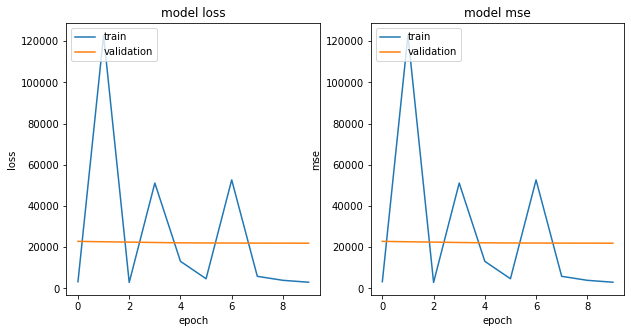

In [105]:
plot_curves(history_v1, ['loss', 'mse'])

In [ ]:
model_v1.predict()